In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AdamW

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/jvirma/code-smell-prototype/master/src/long_method.csv", sep=",")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Define a custom dataset class
class CodeDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        code = self.data.loc[idx, 'codesample']
        label = self.data.loc[idx, 'labels']

        # Encode the code sample with the tokenizer
        inputs = self.tokenizer(code, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        inputs = {key: tensor.squeeze(0) for key, tensor in inputs.items()}
        return inputs, label

    def __len__(self):
        return len(self.data)

# Create an instance of your custom dataset
dataset = CodeDataset(df, tokenizer)

# Split your dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])



# Initialize dataloaders for your training and validation datasets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8)

In [5]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base")

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=0.0001)
num_training_steps = 1000
num_warmup_steps = 100
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-5, total_steps=num_training_steps, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, pct_start=float(num_warmup_steps)/float(num_training_steps))
losses = []
Accuracy = []


# Fine-tune the model
model.train()
for epoch in range(3): # Replace 3 with the number of epochs you want to run
    for batch in train_dataloader:
        inputs = batch[0]
        labels = batch[1]
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()

    # Evaluate the model on the validation dataset after each epoch
    model.eval()
    num_correct = 0
    num_total = 0
    for batch in val_dataloader:
        inputs = batch[0]
        labels = batch[1]
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            num_correct += torch.sum(predictions == labels)
            num_total += len(labels)

    accuracy = float(num_correct) / num_total
    print("Epoch {}: Accuracy: {:.2f}%".format(epoch+1, accuracy*100))
    print("Loss: {:.2f}".format(loss))
    losses.append(loss)
    Accuracy.append(accuracy)

    # Put the model back in training mode
    model.train()     

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Epoch 1: Accuracy: 67.74%
Loss: 0.52
Epoch 2: Accuracy: 96.77%
Loss: 0.22
Epoch 3: Accuracy: 100.00%
Loss: 0.06


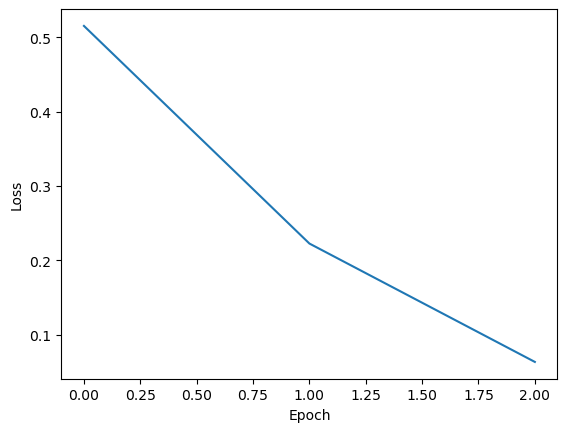

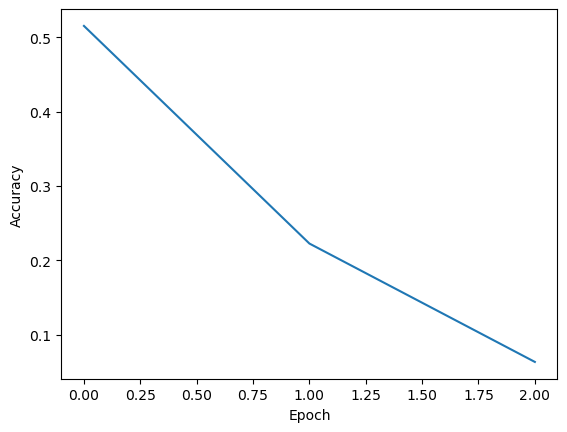

In [10]:
# generate plots
import matplotlib.pyplot as plt
import numpy as np

plt.plot(torch.tensor(losses).detach().numpy())
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


plt.plot(torch.tensor(losses).detach().numpy())
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# specify the path to your saved model
model_path = "./codebert-finetuned"

# load the saved model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# predict
Smell = """
public void performAuthentication(String username, String password) {
  if (StringUtils.isNotBlank(username) && StringUtils.isNotBlank(password)) {
    User user = userRepository.findByUsername(username);
    if (user != null) {
      String hashedPassword = HashUtils.hash(password);
      if (hashedPassword.equals(user.getPassword())) {
        String authToken = TokenUtils.generateToken(user);
        HttpSession session = request.getSession();
        session.setAttribute("authToken", authToken);
        session.setAttribute("user", user);
        response.sendRedirect("/home");
      } else {
        response.sendRedirect("/login?error=invalidPassword");
      }
    } else {
      response.sendRedirect("/login?error=invalidUsername");
    }
  } else {
    response.sendRedirect("/login?error=missingCredentials");
  }
}
 if (order.isValid()) {
    if (order.isInStock()) {
      if (order.isPaid()) {
        if (order.isShipped()) {
          // log success message
        } else {
          order.ship();
          // log success message
        }
      } else {
        order.pay();
        // log success message
      }
    } else {
      // log out-of-stock error
    }
  } else {
    // log invalid order error
  }
"""
print(Smell)

inputs = tokenizer(Smell, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

# check if the input has two dimensions
if len(inputs["input_ids"].shape) == 1:
    inputs["input_ids"] = torch.unsqueeze(inputs["input_ids"], 0)
    inputs["attention_mask"] = torch.unsqueeze(inputs["attention_mask"], 0)

# Make prediction
outputs = model(**inputs)

# Get predicted class and probabilities
predicted_class = outputs.logits.argmax().item()
probs = outputs.logits.softmax(dim=1).detach().numpy()[0]

print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probs}")

# predict
NoSmell = """
public void performAuthentication(String username, String password) {
  if (StringUtils.isNotBlank(username) && StringUtils.isNotBlank(password)) {
    return;
  }
  User user = userRepository.findByUsername(username);
  if (user != null) {
    String hashedPassword = HashUtils.hash(password);
    if (hashedPassword.equals(user.getPassword())) {
      String authToken = TokenUtils.generateToken(user);
      HttpSession session = request.getSession();
      session.setAttribute("authToken", authToken);
      session.setAttribute("user", user);
      response.sendRedirect("/home");
    } else {
      response.sendRedirect("/login?error=invalidPassword");
    }
  } else {
    response.sendRedirect("/login?error=invalidUsername");
  }
}
"""

inputs = tokenizer(NoSmell, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
# check if the input has two dimensions
if len(inputs["input_ids"].shape) == 1:
    inputs["input_ids"] = torch.unsqueeze(inputs["input_ids"], 0)
    inputs["attention_mask"] = torch.unsqueeze(inputs["attention_mask"], 0)

# Make prediction
outputs = model(**inputs)

# Get predicted class and probabilities
predicted_class = outputs.logits.argmax().item()
probs = outputs.logits.softmax(dim=1).detach().numpy()[0]

print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probs}")





public void performAuthentication(String username, String password) {
  if (StringUtils.isNotBlank(username) && StringUtils.isNotBlank(password)) {
    User user = userRepository.findByUsername(username);
    if (user != null) {
      String hashedPassword = HashUtils.hash(password);
      if (hashedPassword.equals(user.getPassword())) {
        String authToken = TokenUtils.generateToken(user);
        HttpSession session = request.getSession();
        session.setAttribute("authToken", authToken);
        session.setAttribute("user", user);
        response.sendRedirect("/home");
      } else {
        response.sendRedirect("/login?error=invalidPassword");
      }
    } else {
      response.sendRedirect("/login?error=invalidUsername");
    }
  } else {
    response.sendRedirect("/login?error=missingCredentials");
  }
}
 if (order.isValid()) {
    if (order.isInStock()) {
      if (order.isPaid()) {
        if (order.isShipped()) {
          // log success message
        } else {
 